In [1]:
import cudf.pandas
cudf.pandas.install()
import pandas as pd

from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

import os
from dotenv import load_dotenv

In [2]:
# === LLM setup
load_dotenv(override=True)

llm = ChatOpenAI(
    model="qwen/qwen3-coder-480b-a35b-instruct",
    api_key=os.getenv("NVIDIA_API_KEY"),
    base_url="https://integrate.api.nvidia.com/v1",
    temperature=0.1,
    max_tokens=500,
)

In [3]:
# === Sample Data ===
df = pd.DataFrame({
    'date': pd.date_range('2024-01-01', periods=10),
    'sales': [1_000_000, 120, 115, 140, 160, 155, 180, 190, 185, 200],
    'profit': [20, 25, 23, 30, 35, 33, 40, 42, 41, 45]
})

In [4]:
# === Tools ===
@tool
def execute_python(code: str) -> str:
    """Execute Python code to analyze the DataFrame 'df'. 
    Variables available: df (pandas DataFrame), pd (pandas module).
    Store your result in a variable called 'result' to return it.
    """
    try:
        local_vars = {"df": df, "pd": pd}
        exec(code, {"__builtins__": __builtins__, "pd": pd}, local_vars)
        return str(local_vars.get("result", "Code executed. Use 'result' variable."))
    except Exception as e:
        return f"Error: {str(e)}"

In [5]:
# === Nodes ===
def planner_agent(state: MessagesState):
    """Decides what analysis to perform"""
    system = SystemMessage(content="""You are a planning agent. 
    Analyze the user's question and describe what calculation needs to be done.
    Be specific about the operation (mean, sum, max, etc.) and column.""")
    
    messages = [system] + state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}

def coder_agent(state: MessagesState):
    """Generates and executes code"""
    system = SystemMessage(content=f"""You are a coding agent.
    DataFrame 'df' has columns: {list(df.columns)}.
    Sample data: {df.head(3).to_string()}
    
    Write Python code to solve the task. Store the answer in 'result'.""")
    
    llm_with_tools = llm.bind_tools([execute_python])
    messages = [system] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: MessagesState):
    """Route to tools or end"""
    return "tools" if state["messages"][-1].tool_calls else END

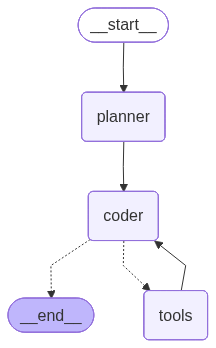

In [6]:
# === Build Graph ===
graph = StateGraph(MessagesState)
graph.add_node("planner", planner_agent)
graph.add_node("coder", coder_agent)
graph.add_node("tools", ToolNode([execute_python]))
# Define flow: START -> Planner -> Coder -> Tools (if needed) -> END
graph.add_edge(START, "planner")
graph.add_edge("planner", "coder")
graph.add_conditional_edges("coder", should_continue, ["tools", END])
graph.add_edge("tools", "coder")
# With LangGraph API, persistence is handled automatically by the platform.
# agent = graph.compile(checkpointer=MemorySaver())
agent = graph.compile()
agent

In [7]:
# === Standalone Execution ===
if __name__ == "__main__":
    prompt = "What are the average sales?"
    result = agent.invoke({"messages": [HumanMessage(content=prompt)]})
    print("\n" + "="*60)
    print("AGENT RESPONSE:")
    print("="*60)
    print(result['messages'][-1].content)


AGENT RESPONSE:
The average sales is 100144.5.
